⏰ **Only can run in CPU**

In [1]:
import tensorflow as tf
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2
from google.protobuf import text_format
import os, subprocess, re
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import shutil
import json
from google.protobuf import text_format
import pprint
import random
from pathlib import Path
from google.protobuf import text_format

%matplotlib inline

### import kaggle API & dataset

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"weipopopo","key":"cf7214aace28ce180ae40cd09062b8b5"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d kneroma/tacotrashdataset
! kaggle datasets download -d bouweceunen/trained-models-taco-trash-annotations-in-context

100% 2.78G/2.79G [00:29<00:00, 62.2MB/s]
100% 2.79G/2.79G [00:29<00:00, 102MB/s] 
 88% 97.0M/111M [00:01<00:00, 102MB/s] 
100% 111M/111M [00:01<00:00, 101MB/s] 


In [5]:
! mkdir garbage
! unzip trained-models-taco-trash-annotations-in-context.zip -d garbage

! mkdir garbage_data
! unzip tacotrashdataset.zip -d garbage_data

Archive:  trained-models-taco-trash-annotations-in-context.zip
  inflating: garbage/ssd_mobilenet_v2_taco_2018_03_29.engine  
  inflating: garbage/ssd_mobilenet_v2_taco_2018_03_29.pb  
  inflating: garbage/ssd_mobilenet_v2_taco_2018_03_29.uff  
Archive:  tacotrashdataset.zip
  inflating: garbage_data/best-checkpoint-003epoch.bin  
  inflating: garbage_data/data/annotations.json  
  inflating: garbage_data/data/batch_1/000000.jpg  
  inflating: garbage_data/data/batch_1/000001.jpg  
  inflating: garbage_data/data/batch_1/000003.jpg  
  inflating: garbage_data/data/batch_1/000004.jpg  
  inflating: garbage_data/data/batch_1/000005.jpg  
  inflating: garbage_data/data/batch_1/000006.jpg  
  inflating: garbage_data/data/batch_1/000007.jpg  
  inflating: garbage_data/data/batch_1/000008.jpg  
  inflating: garbage_data/data/batch_1/000010.jpg  
  inflating: garbage_data/data/batch_1/000011.jpg  
  inflating: garbage_data/data/batch_1/000012.jpg  
  inflating: garbage_data/data/batch_1/000013

### import library

In [6]:
# needed to install object_detection library and enlarge labels
! rm -rf ./models && git clone --depth 1 https://github.com/tensorflow/models.git -b v1.13.0 \
    && sed -i "s#ImageFont.truetype('arial.ttf', 24)#ImageFont.truetype('arial.ttf', 50)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && cp /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf /usr/share/fonts/truetype/dejavu/arial.ttf

Cloning into 'models'...
remote: Enumerating objects: 2927, done.
remote: Counting objects: 100% (2927/2927), done.
remote: Compressing objects: 100% (2428/2428), done.
remote: Total 2927 (delta 503), reused 2114 (delta 424), pack-reused 0
Receiving objects: 100% (2927/2927), 369.04 MiB | 29.30 MiB/s, done.
Resolving deltas: 100% (503/503), done.
Note: switching to '57e075203f8fba8d85e6b74f17f63d0a07da233a'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

Updating files: 100% (2768/2768), done.
cp: cannot stat '/usr/share/fon

In [7]:
! pip3 install pycocotools > /dev/null
! cd ./models/research && \
    protoc object_detection/protos/*.proto --python_out=. && \
    python3 setup.py build > /dev/null && \
    python3 setup.py bdist_wheel > /dev/null
! python3 -m pip install --no-cache-dir ./models/research/dist/object_detection-0.1-py3-none-any.whl > /dev/null
! cd ./models/research/slim && \
    python3 setup.py bdist_wheel > /dev/null
! python3 -m pip install --no-cache-dir ./models/research/slim/dist/slim-0.1-py3-none-any.whl > /dev/null

/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.g

In [8]:
# install object_detection library
! cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . && \
    python3 -m pip install --use-feature=2020-resolver .

cp: cannot stat 'object_detection/packages/tf2/setup.py': No such file or directory


In [9]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2

### Reconstruct Model

In [10]:
# reconstruct frozen graph
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

### Detection Function

In [11]:
# visualize detection
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )

            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=15)

            for i in range(int(num[0])):
                class_name = category_index[int(classes[0, i])]['name']
                score = scores[0, i] * 100
                recycle = category_index[int(classes[0, i])]['recycle']
                box = np.squeeze(boxes)[i]
                print(f"物件{i+1}: 類別: {class_name}, Score: {score:.0f}%, {recycle}")

            plt.figure(figsize=(12, 8))
            plt.imshow(npim)
            plt.show()

# Create LabelMap

First we need to create the label map.

In [12]:
! git clone https://github.com/pedropro/TACO.git

Cloning into 'TACO'...
remote: Enumerating objects: 740, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 740 (delta 117), reused 129 (delta 88), pack-reused 580
Receiving objects: 100% (740/740), 98.85 MiB | 20.52 MiB/s, done.
Resolving deltas: 100% (494/494), done.


In [13]:
DATA_DIR = '/content/TACO/data'
ANNOTATIONS_FILE = os.path.join(DATA_DIR, 'annotations.json')
NCLASSES = 60

In [14]:
with open(ANNOTATIONS_FILE) as json_file:
    data = json.load(json_file)

categories = data['categories']

In [ ]:
print('Building label map from examples')

labelmap = string_int_label_map_pb2.StringIntLabelMap()
for idx,category in enumerate(categories):
    item = labelmap.item.add()
    # label map id 0 is reserved for the background label
    item.id = int(category['id'])+1
    item.name = category['name']

with open('./labelmap.pbtxt', 'w') as f:
    f.write(text_format.MessageToString(labelmap))

print('Label map witten to labelmap.pbtxt')

with open('./labelmap.pbtxt') as f:
    pprint.pprint(f.readlines())

In [16]:
from object_detection.utils import label_map_util

# 替換舊的 load_labelmap 函數
def load_labelmap(path):
    with open(path, 'r') as file:
        labelmap_str = file.read()
    label_map = string_int_label_map_pb2.StringIntLabelMap()
    try:
        text_format.Merge(labelmap_str, label_map)
    except text_format.ParseError:
        label_map.ParseFromString(labelmap_str)
    return label_map

# 載入 label map
label_map_path = 'labelmap.pbtxt'  # 替換為實際路徑
label_map = load_labelmap(label_map_path)

# 將 label map 轉換為 categories
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NCLASSES, use_display_name=True
)

# 創建 category index
category_index = label_map_util.create_category_index(categories)

In [17]:
for item_id, item_info in category_index.items():
    if item_info['id'] in [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                           22, 24, 25, 27, 28, 29, 30, 31, 34, 35, 36,
                           45, 47, 48, 51, 53, 54, 55, 58]:
        category_index[item_id]['recycle'] = '資源回收'
    else:
        category_index[item_id]['recycle'] = '一般垃圾'

In [18]:
# for category_id, info in category_index.items():
#     if info['recycle'] == '一般垃圾':
#         print(f"{category_id}: {info['name']}")

# Reconstruct Frozen Graph

Now we are going to reconstruct the TensorFlow frozen graph (.pb).

In [19]:
detection_graph = reconstruct("garbage/ssd_mobilenet_v2_taco_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


# Validate Test Images

We can now test it on some test images. (in TACO dataset)

物件1: 類別: Clear plastic bottle, Score: 98%, 資源回收


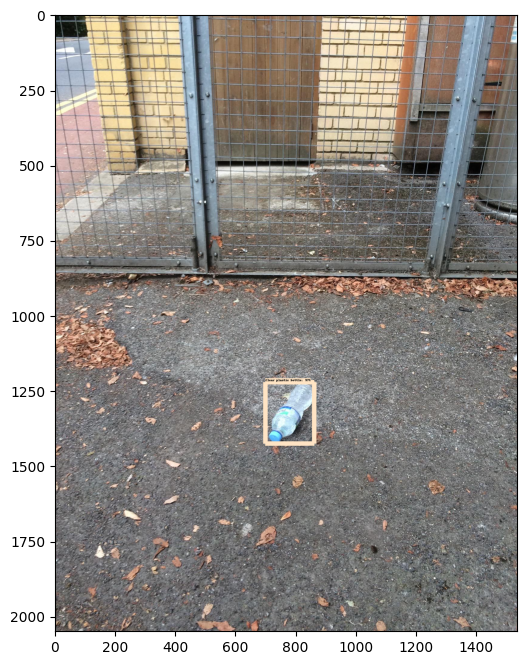

物件1: 類別: Plastic bottle cap, Score: 99%, 資源回收
物件2: 類別: Other plastic bottle, Score: 97%, 資源回收


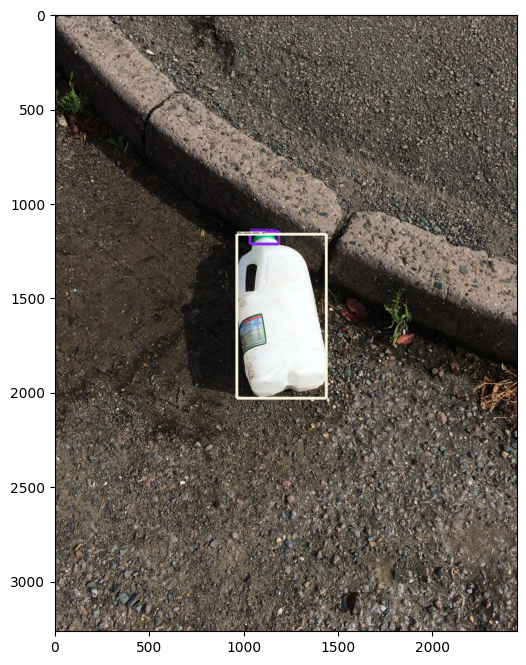

Skipping batch_3 because image not found.
物件1: 類別: Plastic bottle cap, Score: 77%, 資源回收


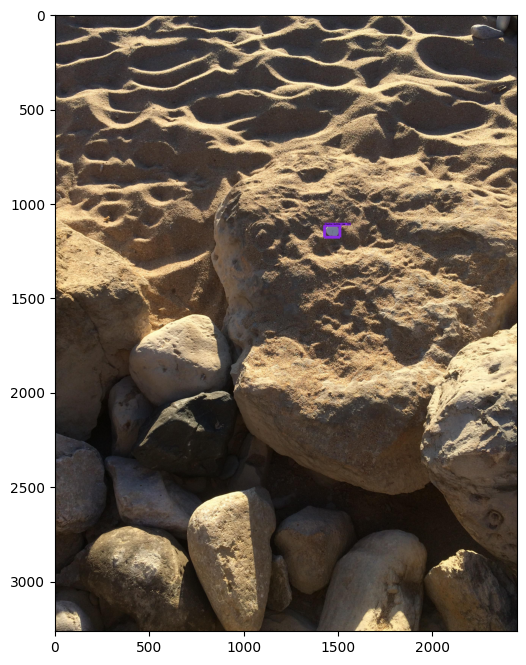

物件1: 類別: Clear plastic bottle, Score: 89%, 資源回收
物件2: 類別: Cigarette, Score: 15%, 一般垃圾
物件3: 類別: Cigarette, Score: 13%, 一般垃圾


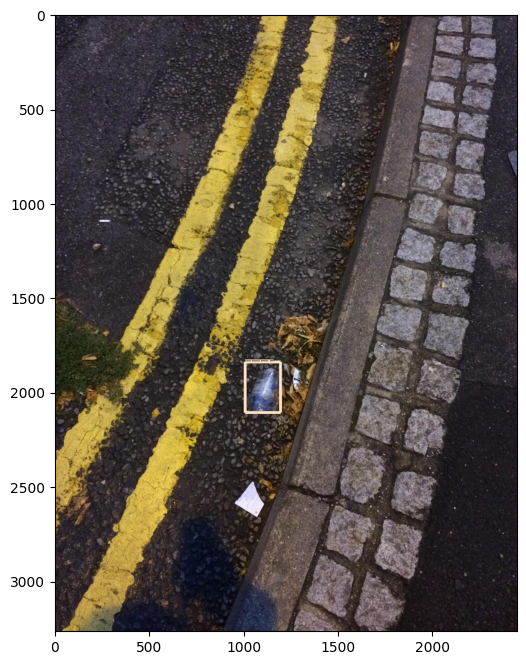

物件1: 類別: Disposable plastic cup, Score: 60%, 資源回收


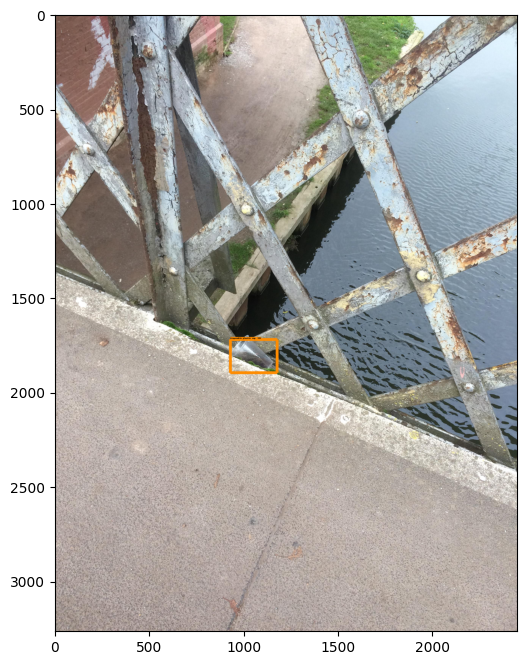

In [46]:
image_template = 'garbage_data/data/batch_{}/{}'

for batch_number in range(1, 7):
    image_path = image_template.format(batch_number, '000000.JPG')
    # 如果 JPG 檔案不存在，試著使用小寫的 jpg
    if not os.path.exists(image_path):
        image_path = image_template.format(batch_number, '000000.jpg')

        if not os.path.exists(image_path):
            print(f"Skipping batch_{batch_number} because image not found.")
            continue

    # 呼叫 detect 函數
    detect(detection_graph, image_path)

物件1: 類別: Clear plastic bottle, Score: 100%, 資源回收
物件2: 類別: Plastic bottle cap, Score: 99%, 資源回收


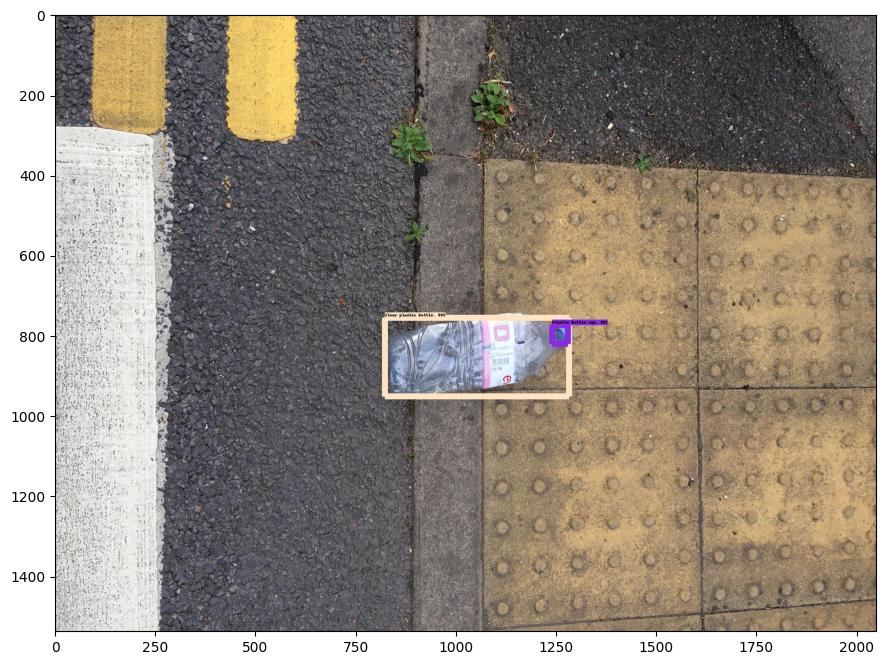

In [ ]:
detect(detection_graph, 'garbage_data/data/batch_1/000001.jpg')

物件1: 類別: Other plastic wrapper, Score: 89%, 一般垃圾


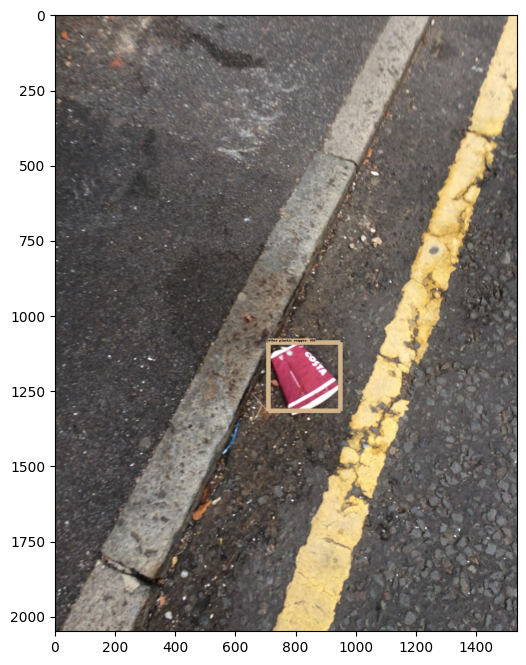

In [47]:
detect(detection_graph, 'garbage_data/data/batch_1/000003.jpg')

物件1: 類別: Clear plastic bottle, Score: 83%, 資源回收
物件2: 類別: Clear plastic bottle, Score: 11%, 資源回收


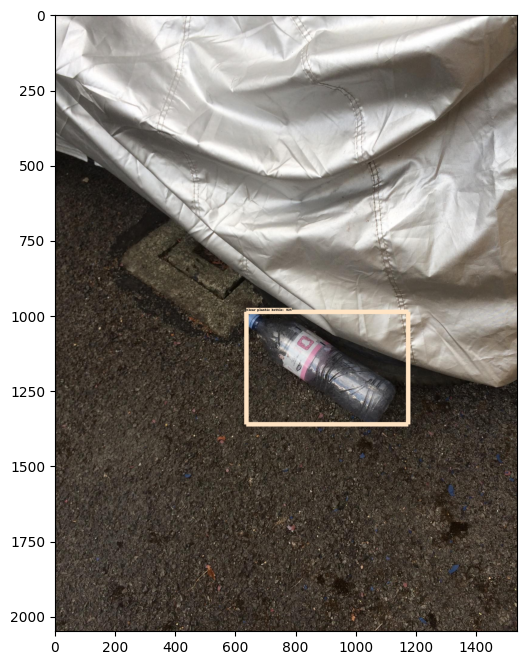

In [48]:
detect(detection_graph, 'garbage_data/data/batch_1/000010.jpg')

# Validate Our Images

In [25]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive') # 此處需要登入google帳號)

Mounted at /content/gdrive


We can now test it on some test images. (in Taiwan)

物件1: 類別: Drink can, Score: 87%, 資源回收
物件2: 類別: Drink can, Score: 29%, 資源回收
物件3: 類別: Other plastic bottle, Score: 28%, 資源回收
物件4: 類別: Drink can, Score: 26%, 資源回收
物件5: 類別: Clear plastic bottle, Score: 20%, 資源回收
物件6: 類別: Paper cup, Score: 14%, 一般垃圾
物件7: 類別: Plastic bottle cap, Score: 12%, 資源回收


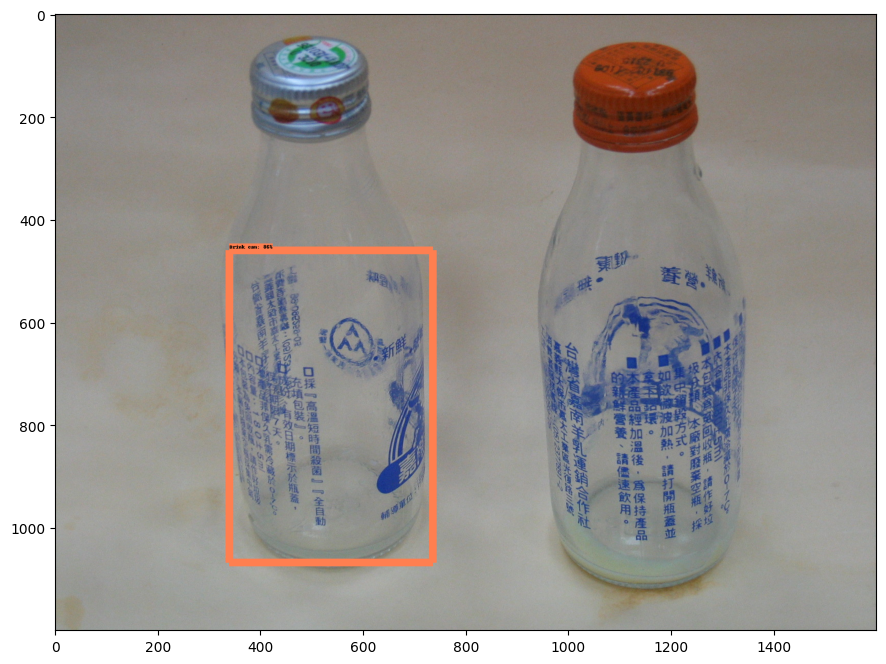

In [41]:
detect(detection_graph, '/content/gdrive/MyDrive/PR/Final/Test_Data/glass.jpeg')

物件1: 類別: Paper cup, Score: 99%, 一般垃圾
物件2: 類別: Plastic film, Score: 69%, 一般垃圾
物件3: 類別: Paper cup, Score: 23%, 一般垃圾
物件4: 類別: Plastic lid, Score: 22%, 資源回收


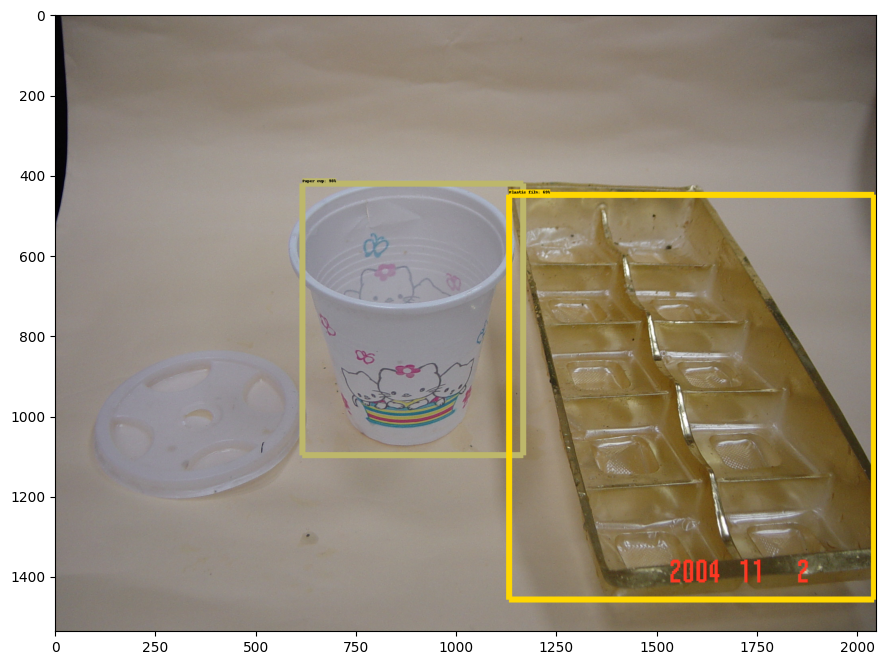

In [40]:
detect(detection_graph, '/content/gdrive/MyDrive/PR/Final/Test_Data/food.jpeg')

物件1: 類別: Crisp packet, Score: 80%, 一般垃圾
物件2: 類別: Other carton, Score: 60%, 資源回收
物件3: 類別: Other plastic wrapper, Score: 25%, 一般垃圾
物件4: 類別: Drink carton, Score: 16%, 資源回收


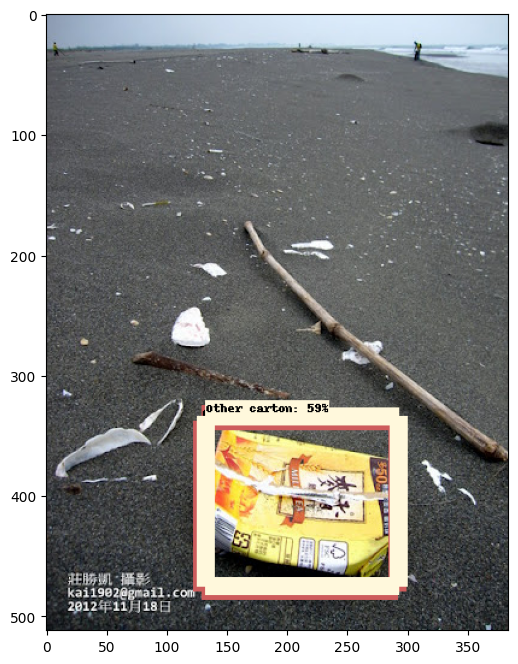

In [45]:
detect(detection_graph, '/content/gdrive/MyDrive/PR/Final/Test_Data/sea.jpeg')

In [ ]:
! rm -rf ./models